# Think School YouTube Channel Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from googleapiclient.discovery import build
import pytz
import isodate

In [2]:
# Youtube API acceess
api_key = "User your youtueb api here" 
channel_id = ["UCKZozRVHRYsYHGEyNKuhhdA",]
api_service_name = "youtube"
api_version = "v3"
youtube = build(api_service_name, api_version, developerKey=api_key)

#### Identifing youtuber playlist_id to collect video details

In [3]:
def get_channelDetails(channel_id):
    request = youtube.channels().list(
            part="snippet,contentDetails,statistics",
            id=channel_id
        )
    response = request.execute()
    for i in response["items"]:
        playlistId = i["contentDetails"]["relatedPlaylists"]["uploads"]
    return playlistId

In [4]:
playlistId = get_channelDetails(channel_id) 

In [5]:
# Using playlistId collecting all videoids
playlistId = "UUKZozRVHRYsYHGEyNKuhhdA"
def get_video_data(playlistId):
    nextPageToken = None
    videoIds = []
    while True:
        request = youtube.playlistItems().list(
                part="snippet,contentDetails",
                maxResults=25,
                playlistId=playlistId,
                pageToken = nextPageToken)
        response = request.execute()
        for i in response["items"]:
            videoIds.append(i["contentDetails"]["videoId"])
        nextPageToken = response.get("nextPageToken")
        if not nextPageToken:
            break
    return videoIds
videoIds = get_video_data(playlistId)

In [6]:
## collecting video details using the videoId
def get_video_data(videoIds):
    video_info = []
    for k in range(0,len(videoIds),10):
        request = youtube.videos().list(
                    part="snippet,contentDetails,statistics",
                     id=','.join(videoIds[k:k+10]))
        response = request.execute()
        for i in response["items"]:
            data = {"channelTitle": i["snippet"]["channelTitle"],
                    "videoId": i["id"],
                    "channelId": i["snippet"]["channelId"],
                    "publishedAt": i["snippet"]["publishedAt"],
                    "title": i["snippet"]["title"],
                    "description": i["snippet"]["description"],
                "duration": i["contentDetails"]["duration"],
                   "viewCount": i["statistics"]["viewCount"],
                    "likeCount": i["statistics"]["likeCount"],
                    "commentCount": i["statistics"]["commentCount"],
                   }
            video_info.append(data)
    video_df = pd.DataFrame(video_info)
    return video_df

In [7]:
video_df = get_video_data(videoIds)

### Video Dataset is ready, Lets gets started!

In [8]:
## Checking for null values

In [9]:
video_df.isnull().any() ## No null values

channelTitle    False
videoId         False
channelId       False
publishedAt     False
title           False
description     False
duration        False
viewCount       False
likeCount       False
commentCount    False
dtype: bool

In [10]:
video_df.info()  ## 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346 entries, 0 to 345
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   channelTitle  346 non-null    object
 1   videoId       346 non-null    object
 2   channelId     346 non-null    object
 3   publishedAt   346 non-null    object
 4   title         346 non-null    object
 5   description   346 non-null    object
 6   duration      346 non-null    object
 7   viewCount     346 non-null    object
 8   likeCount     346 non-null    object
 9   commentCount  346 non-null    object
dtypes: object(10)
memory usage: 27.2+ KB


In [11]:
## Data type correction required

In [12]:
video_df["publishedAt"] = pd.to_datetime(video_df["publishedAt"]) 
video_df["publishedAt"] = video_df["publishedAt"].dt.tz_convert("Asia/Kolkata") # UST to IST

In [13]:
num_col = ["viewCount", 'likeCount' , "commentCount"]
video_df[num_col] = video_df[num_col].apply(pd.to_numeric , axis= 1) ## numeric value conversion

## Data Enginnering

In [14]:
video_df["weekDay"] = video_df["publishedAt"].apply(lambda x : x.strftime("%A")) ## weekday extraction
video_df["hour"] = video_df["publishedAt"].apply(lambda x : x.strftime("%H"))

In [15]:
video_df["durationSec"]= video_df["duration"].apply(lambda x: isodate.parse_duration(x)) ## video time duration
video_df["durationSec"]= video_df["durationSec"].astype("timedelta64[s]")

In [16]:
video_df ["engagementCount"] = video_df["likeCount"] + video_df["commentCount"] ## engagement count 
video_df ["engagementRate"] = round(video_df ["engagementCount"]/video_df["viewCount"]*100,0)
video_df ["engagementRate"] = video_df ["engagementRate"].fillna(0)

In [17]:
video_df = video_df[video_df["durationSec"]!=0] ## removing video with zero duration as it couldn't be due to some error

In [18]:
## categorizing video into shorts and full length video  if video duration < 60 sec 
video_df["videoType"] = video_df["durationSec"].apply(lambda x : "shorts" if x <= 60 else "Full Length video")

Text(0.5, 1.0, 'Video Type')

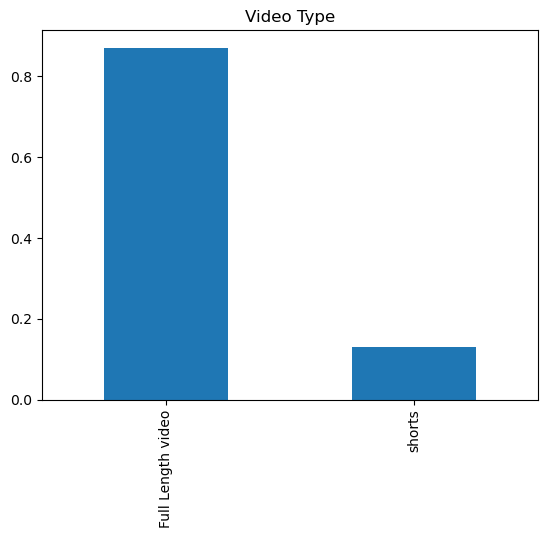

In [19]:
value_counts = video_df["videoType"].value_counts(normalize=True)
ax = value_counts.plot(kind="bar")
plt.title("Video Type")

####  Most common video posting type are Full lenth video with 87% of videos and 13% shorts video

Text(0.5, 1.0, 'Least Viewed Full Length Video')

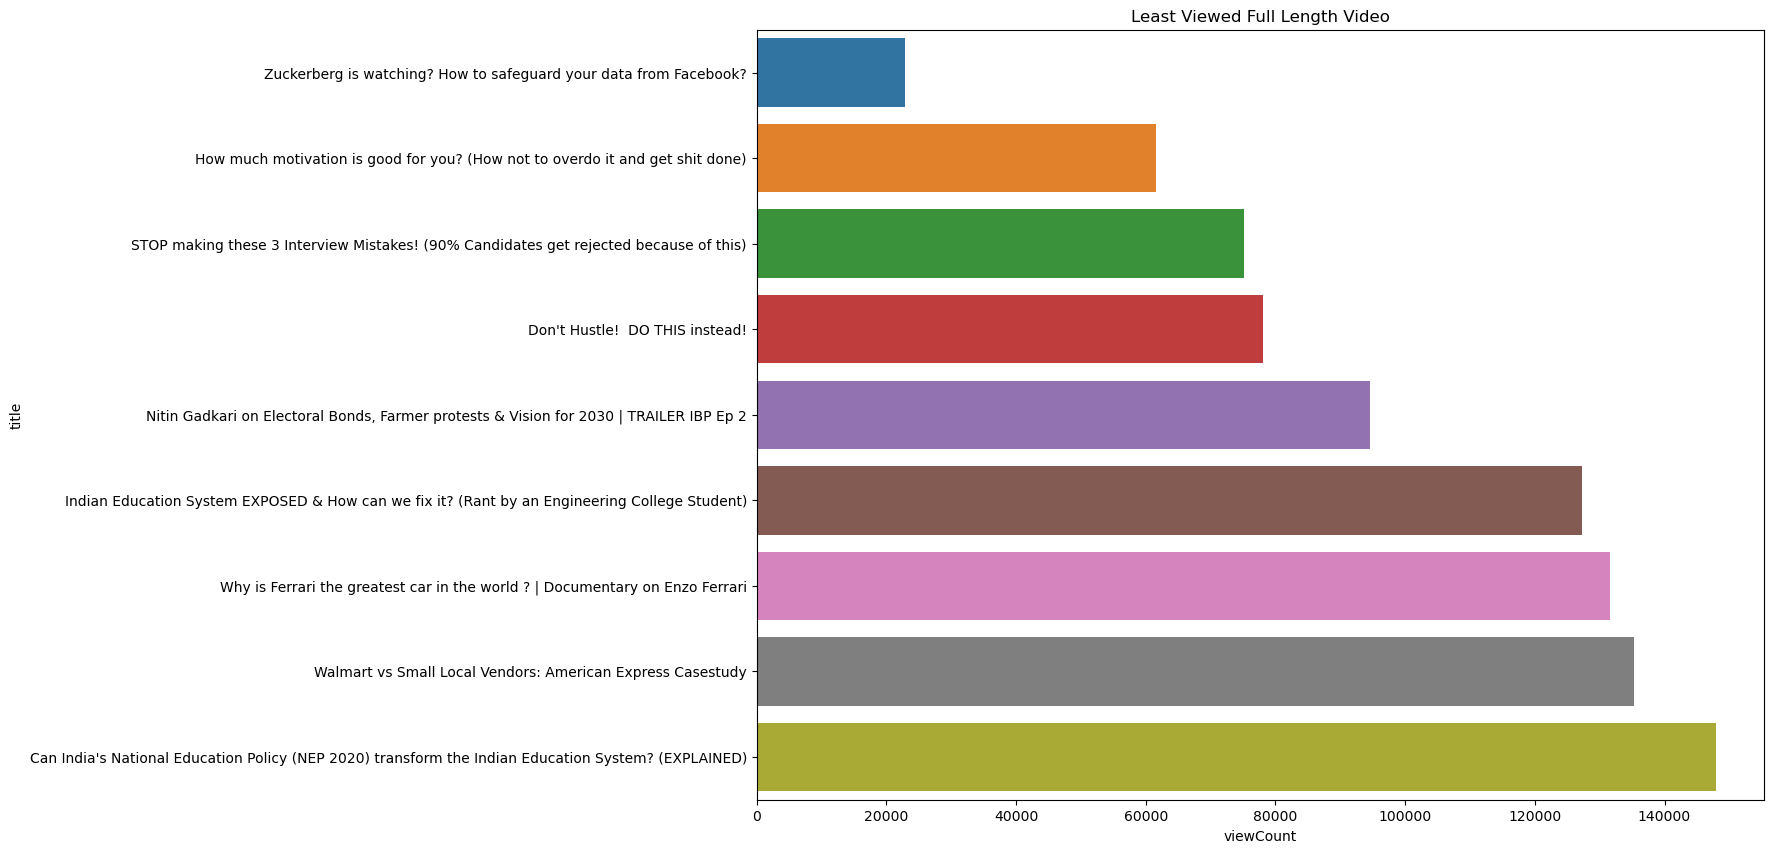

In [20]:
## Least viewed 10 full length Videos by views
plt.figure(figsize=(13,10))
fullVideo_df = video_df[video_df["videoType"] != "shorts"]
sns.barplot(x ="viewCount" , y = "title" ,data = fullVideo_df.sort_values(by = "viewCount" ,ascending = True)[0:9])
plt.title("Least Viewed Full Length Video")

Text(0.5, 1.0, 'Most Viewed Full Length Video')

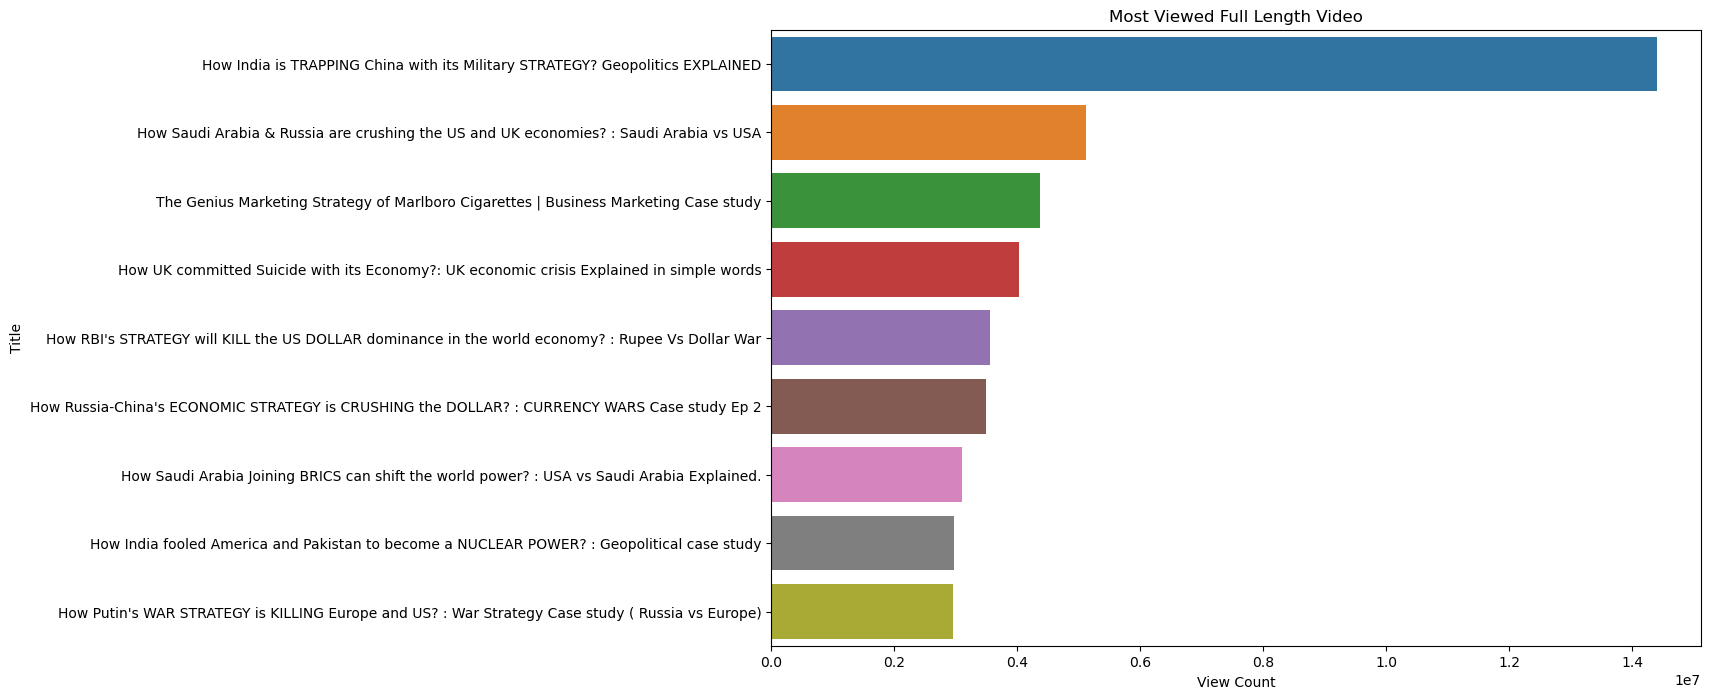

In [21]:
## Most 10 Videos by views
plt.figure(figsize=(12, 8))
sns.barplot(x ="viewCount" , y = "title" ,data = fullVideo_df.sort_values(by = "viewCount" ,ascending = False)[0:9])
plt.xlabel("View Count")
plt.ylabel("Title")
plt.title("Most Viewed Full Length Video")

Text(0.5, 1.0, 'Top Engaging Video')

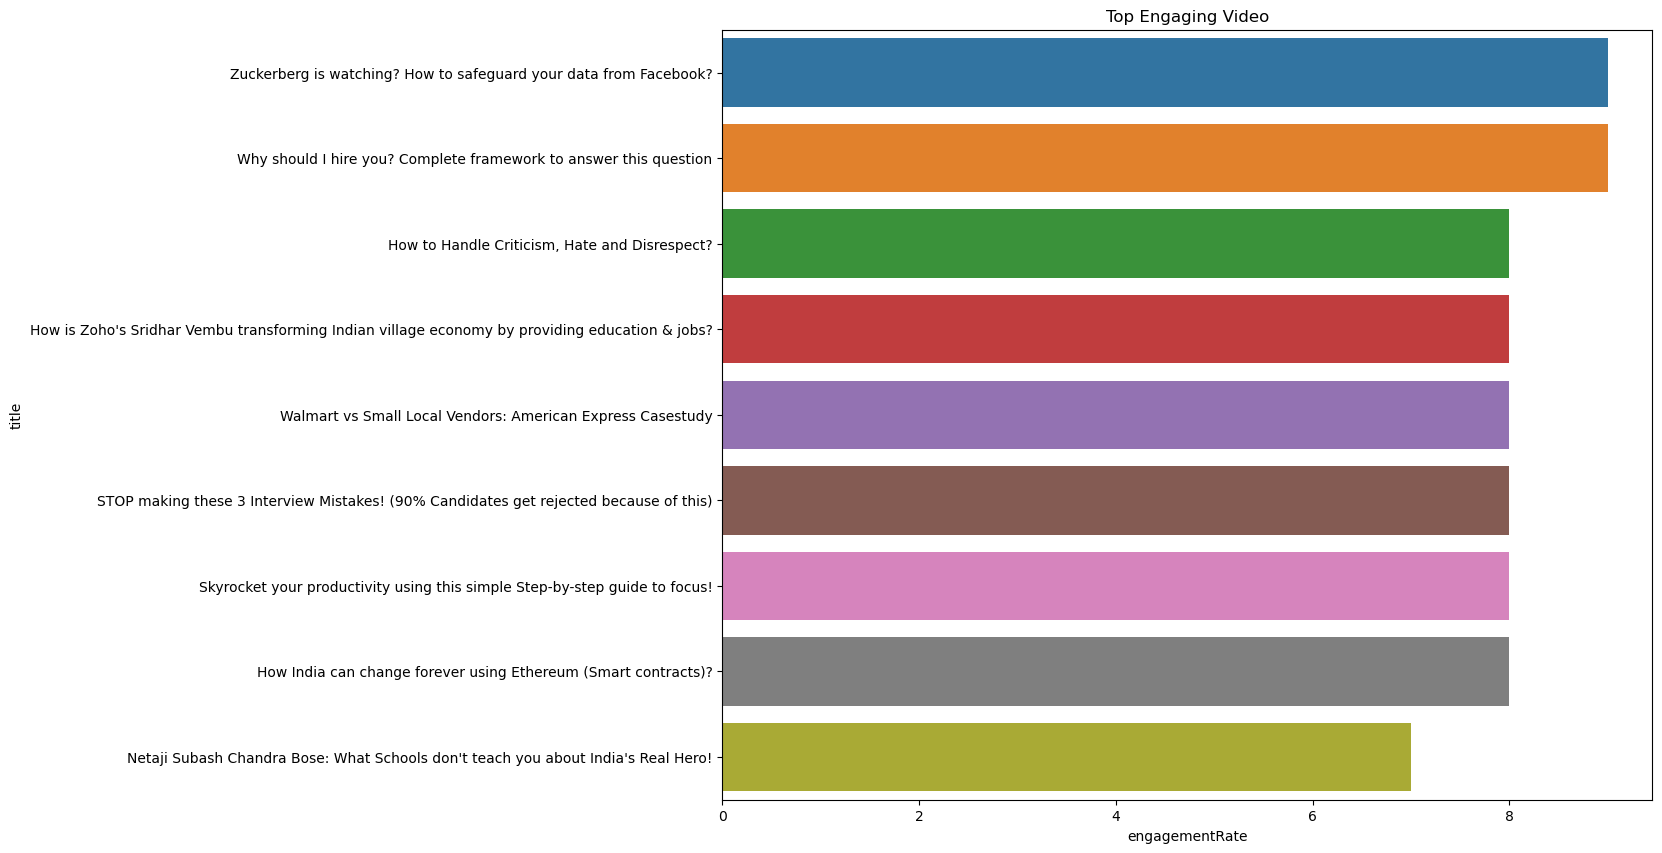

In [22]:
## Most Engagementing videos
plt.figure(figsize=(12,10))
sns.barplot(x="engagementRate" , y = "title", data = fullVideo_df.sort_values(by ="engagementRate" , ascending = False)[0:9])
plt.title("Top Engaging Video")

#### Most viewed full lenth video "How India is tRAPPING CHINA WITH ITS MILITRY STRATEGY"
#### Least viewed full length video "Zuckerberg is watching? How to safeguard your"
#### Most Engagementing videos "How India is tRAPPING CHINA WITH ITS MILITRY STRATEGY"

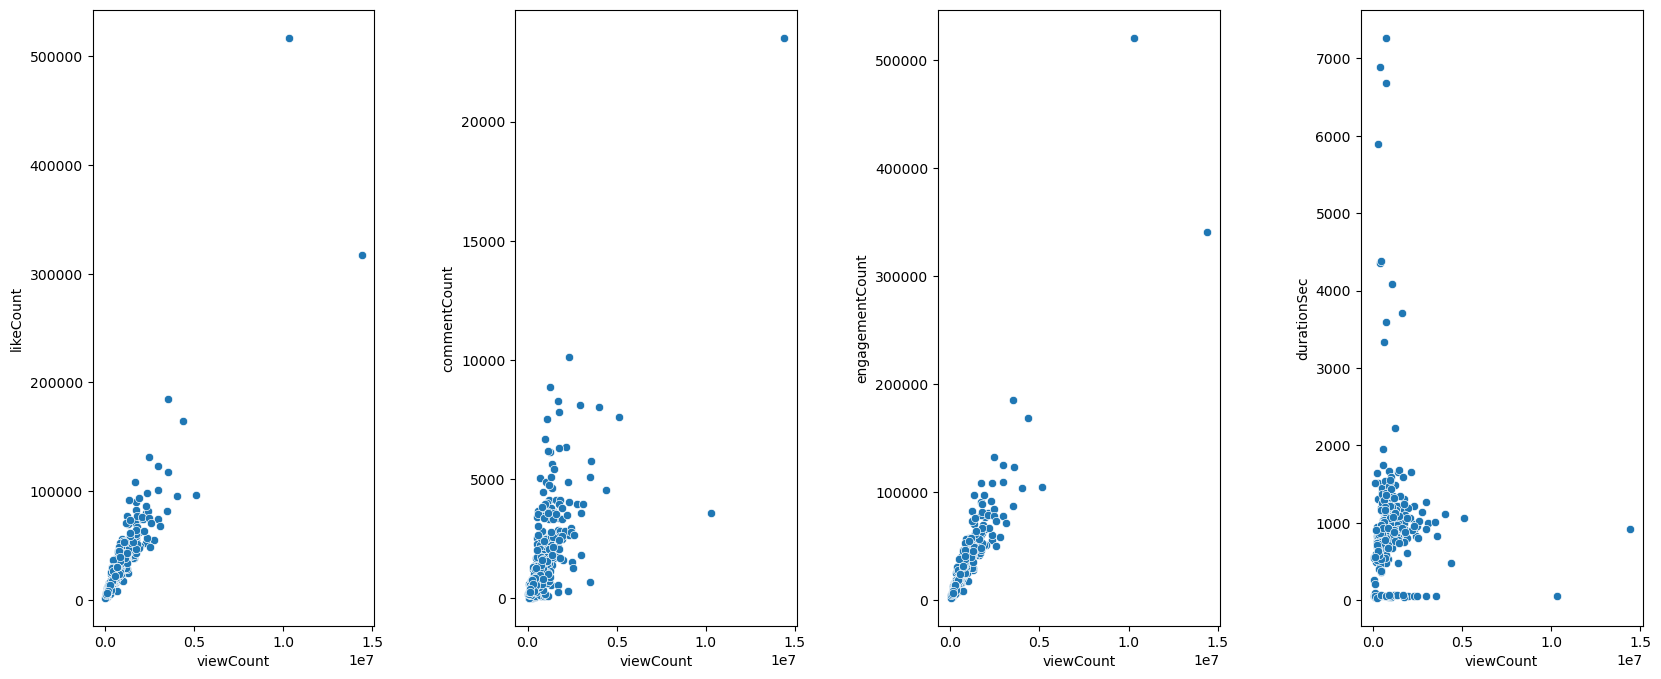

In [23]:
## Analysing video view vs comments vs likes
fig , ax = plt.subplots(1,4,figsize=(20,8))
sns.scatterplot(x = "viewCount", y = "likeCount", data = video_df , ax = ax[0])
sns.scatterplot(x = "viewCount", y = "commentCount", data = video_df , ax = ax[1])
sns.scatterplot(x = "viewCount", y = "engagementCount", data = video_df , ax = ax[2])
sns.scatterplot(x= "viewCount", y= "durationSec", data = video_df , ax = ax[3])
plt.subplots_adjust(wspace= 0.5)


In [24]:
## Video views -> highly correlated with likes and comments

In [25]:
weekDay_df = pd.DataFrame(video_df.groupby("weekDay")["videoId"].count()) ## Analysing weekdays posting pattern 

In [26]:
day =["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
weekDay = weekDay_df.reindex(day)

<AxesSubplot:xlabel='weekDay'>

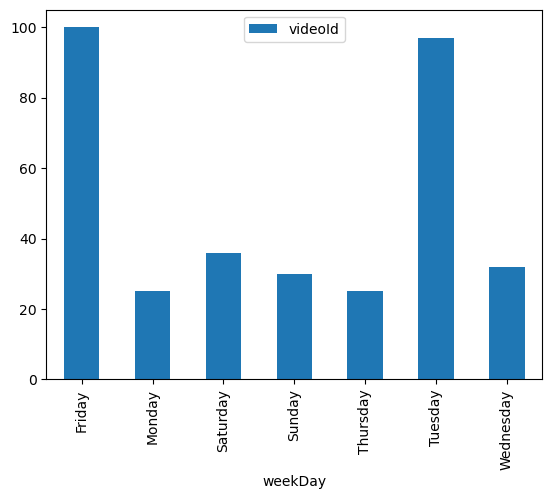

In [27]:
weekDay_df.plot(kind = "bar")

<AxesSubplot:>

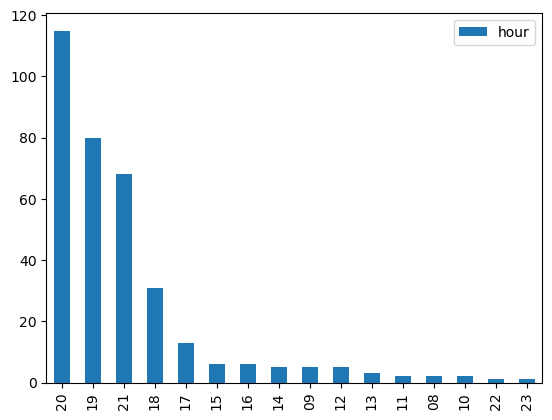

In [28]:
hour_df = pd.DataFrame(video_df["hour"].value_counts()) ## Analysing hourly posting patten 
hour_df.plot(kind="bar")

#### Most common video posting day are tuesday and Friday between 7pm to 9pm

<AxesSubplot:xlabel='viewCount', ylabel='Count'>

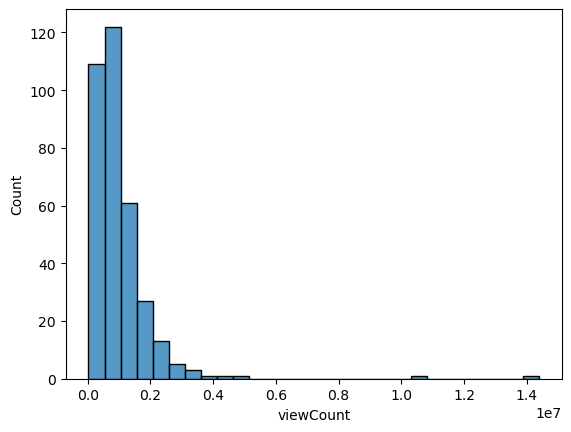

In [29]:
sns.histplot(video_df["viewCount"], bins = 28)

#### Most video are between 4 lakh video to 1M views

<AxesSubplot:xlabel='durationSec', ylabel='Count'>

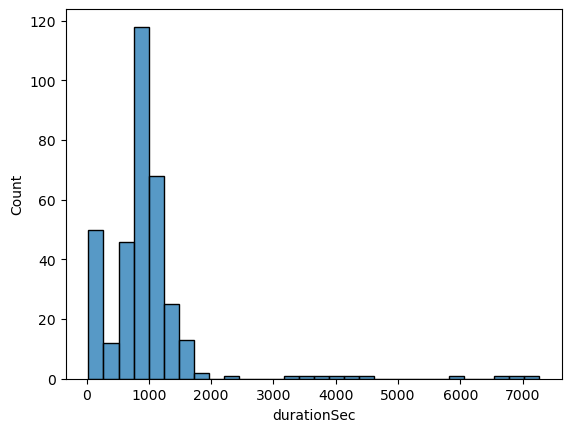

In [30]:
sns.histplot(video_df["durationSec"],bins= 30)

#### More then 50% video are bewteen 750 sec to 1000 sec with avg time duration of 949 sec

In [31]:
video_df["durationSec"].mean()

948.7855072463768

## Analysis

#### Posting Schedule: Most videos posted on Tuesday and Friday between 7 PM to 9 PM.
#### Content Type:  Most common video posting type are Full lenth video with 87% of videos and 13% shorts video
#### View Count Range: Most videos have between 400,000 to 1 million views
#### More than 50% of the videos are between 750 seconds to 1000 seconds in length,that is with average duration of videos is 949 seconds (~16 minutes). 
##### Most Viewed Full Length Video:"How India is TRAPPING CHINA WITH ITS MILITARY STRATEGY"
##### Least Viewed Full Length Video:"Zuckerberg is watching? How to safeguard your data from Facebook? as it is ea"
##### Most Engaging Video:"Zuckerberg is watching? How to safeguard your data from Facebook?"
